# Numerical experiements for the 2d grid
This document reproduces the results of the paper for a two dimensionnal grid.

## 1. Imports

In [1]:
# Maths
import numpy as np
import math 
from math import pi 
# Plot
import matplotlib.pyplot as plt
import seaborn as sns
# Graph
import networkx as nx 
# Utilities
import copy
from tqdm.auto import tqdm
import pandas as pd
import sys
# Fit
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit
# Parallelisation
from multiprocessing import Pool
# QWSearch
from qwgraph import QWSearch,coins,PipeLine,AddressingType,pipelines

# Plot configuration
sns.set()
sns.set_context("poster")
sns.set_style("ticks")

idc = lambda x : np.array(list(range(len(x))))

## 2. Signal of a search
We search one node in the grid according to the procedure explained in the paper.
 1. Generate a grid graph
 2. Starify it
 3. Mark the right virtual edge
 4. Search with the QW

Text(0, 0.5, 'probability of success')

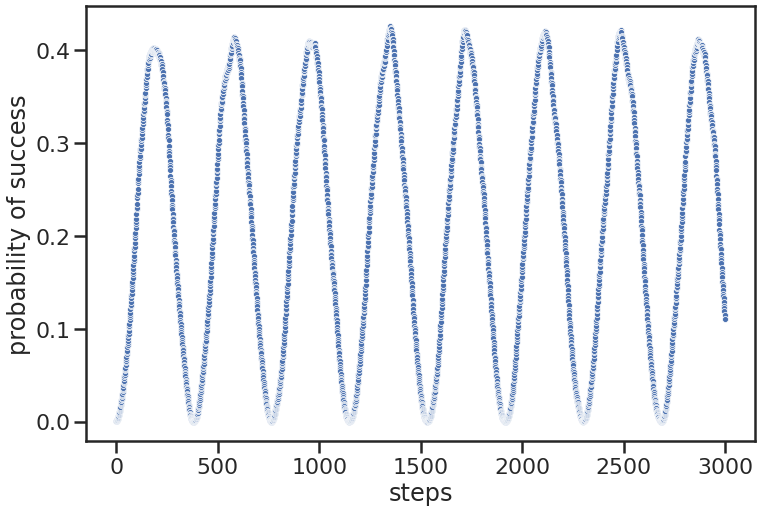

In [2]:
G = nx.convert_node_labels_to_integers(nx.grid_2d_graph(64,64,periodic=True)) # Initial graph : 2d grid of size 64x64
qw = QWSearch(G, starify=True) # Generation of the QW
searched = [0]
p = qw.run(pipelines.search_virtual_edges(coins.X, "grover", searched, -coins.X), ticks=3000) # The signal of the walk

plt.figure(figsize=(12,8))
sns.lineplot(x=idc(p),y=p,marker='.', linestyle='--')
plt.xlabel("steps")
plt.ylabel("probability of success")

## 3. Hitting time and probability of success
We will now compute the hitting time $T$ and the probability of success $P$ for different grid sizes.
The algorithm used to compute the hitting time is as follow:
 1. Set S = [p(0)]
 2. Compute the 30 first steps of the signal S : S = [p(0),...,p(30)]
 3. Set a = argmin(S) and b = argmax(S)
 4. If S[-1] > $\frac{a+b}{2}$ then return (T=b, P=S[b])
 5. Else, compute next step and go back to step 4.

The full code for this can be found in ./pqwfast.py -> fn carac

In [3]:
def lin_fit(x,y):
    X = np.array([[i] for i in x])
    reg = LinearRegression().fit(X, y)
    text = "score : {:.5f}\nintercept : {:.5f}\ncoef : {:.5f}\n".format(reg.score(X,y),reg.intercept_,reg.coef_[0])
    print(text)
    return reg.predict(X), text

In [4]:
def get_T_P(n):
    """
    Parameter:
        n -> The width of the grid.
    Return:
        pandas dataframe with a lot of informations on the search.
    """
    G = nx.convert_node_labels_to_integers(nx.grid_2d_graph(n,n,periodic=True)) # Initial graph : 2d grid of size 64x64
    qw = QWSearch(G, starify=True) # Generation of the QW
    searched = [0]
    T,P = qw.get_T_P(pipelines.search_virtual_edges(coins.X, "grover", searched, -coins.X),waiting=30)
    dic = {"$N$":len(list(G.nodes())), "$M$":len(list(G.edges())), "$\\tilde N$":len(list(qw.nodes())), "$\\tilde M$":len(list(qw.edges())),
            "degree_centrality $G$":nx.degree_centrality(G)[0], "degree_centrality $\\tilde G$":nx.degree_centrality(qw.graph())[0], "$T$":T, "$P$":P,}
    return pd.DataFrame({i : [dic[i]] for i in dic})

get_T_P(64)

,$N$,$M$,$\tilde N$,$\tilde M$,degree_centrality $G$,degree_centrality $\tilde G$,$T$,$P$
0,4096,8192,8192,12288,0.000977,0.00061,188,0.402563


In [5]:
# This cell compute data for a lot of grid size (might take a while).
grid_sizes = list(range(32,250,5))
np.random.shuffle(grid_sizes)
with Pool(16) as p:
    data = pd.concat(list(tqdm(p.imap_unordered(get_T_P,grid_sizes), total=len(grid_sizes), desc="Computing hitting time and probability of success for various grid sizes")))

Computing hitting time and probability of success for various grid sizes:   0%|          | 0/44 [00:00<?, ?it/…

### 3.1 Hitting time

score : 0.99977
intercept : -8.41670
coef : 0.58237



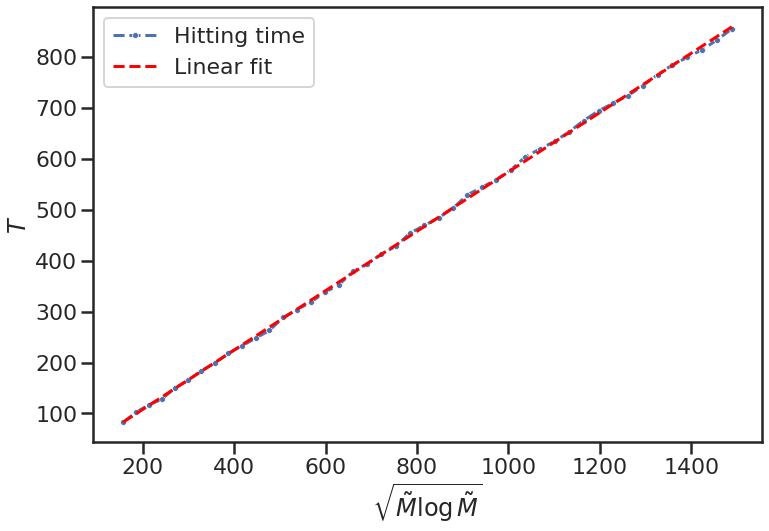

In [6]:
x = np.array(data["$\\tilde M$"])
xx = np.sqrt(x*np.log(x))
y = np.array(list(data["$T$"]))
z, text = lin_fit(xx,y)

plt.figure(figsize=(12,8))
sns.lineplot(x=xx,y=y,marker='.', linestyle='--',label="Hitting time")
sns.lineplot(x=xx,y=z, linestyle='--', color="red", label="Linear fit")
plt.annotate(text, xy=(40, 200),color="red")
plt.xlabel("$\\sqrt{\\tilde M \\log \\tilde M}$")
plt.ylabel("$T$")
plt.savefig("img/grid_T.png", bbox_inches='tight')

score : 0.99958
intercept : -43.50664
coef : 3.62436



Text(0, 0.5, '$T$')

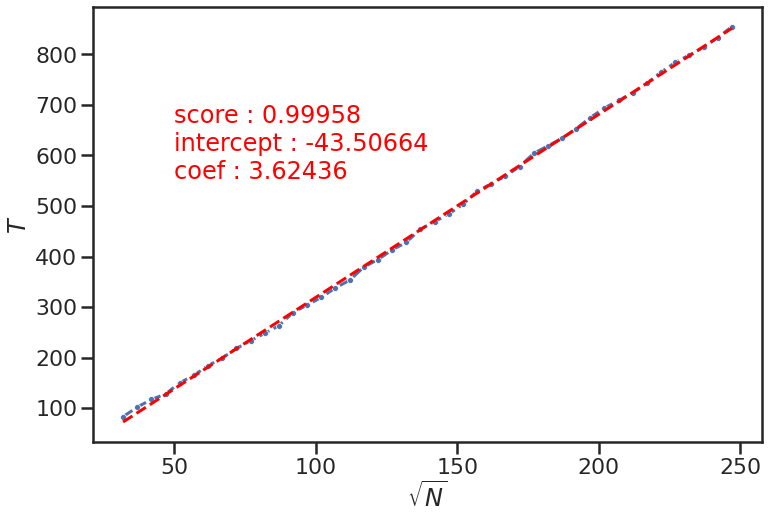

In [7]:
x = np.sqrt(data["$N$"])
y = np.array(list(data["$T$"]))
z, text = lin_fit(x,y)

plt.figure(figsize=(12,8))
sns.lineplot(x=x,y=y,marker='.', linestyle='--')
sns.lineplot(x=x,y=z, linestyle='--', color="red")
plt.annotate(text, xy=(50, 500),color="red")
plt.xlabel("$\\sqrt{N}$")
plt.ylabel("$T$")

### 3.2 Probability of success

score : 0.71560
intercept : 0.40280
coef : -0.00000

0.9999892681478091
score: 0.99999
model: $y=\frac{a}{\log bx}+c$
a = 1.99714
b = 0.45485
c = 0.17089


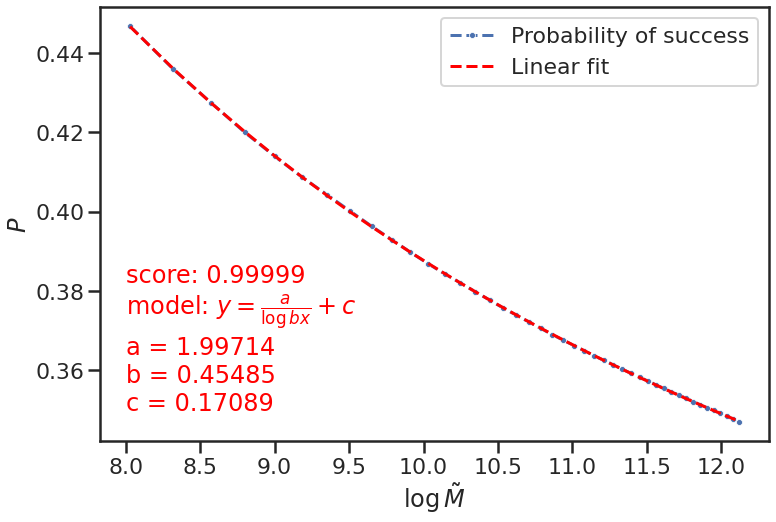

In [8]:
x = np.array(list(data["$\\tilde M$"]))
y = np.array(list(data["$P$"]))
x = x
z, text = lin_fit(x,y)

model = lambda x,a,b,c:a/np.log(b*x)+c
param = curve_fit(model,x,y,p0=[0.5,0.5,0.5],maxfev=100000)[0]
z = model(x,*param)

score = 1-np.mean((y-z)**2)/np.std(y)**2

print(score)
formula = r"$y=\frac{a}{\log bx}+c$"
text = "score: {}\nmodel: {}\na = {}\nb = {}\nc = {}".format(np.round(score,5),formula,*np.round(param,5))

print(text)

plt.figure(figsize=(12,8))
sns.lineplot(x=np.log(x),y=y,marker='.', linestyle='--', label="Probability of success")
sns.lineplot(x=np.log(x),y=z, linestyle='--', color="red", label="Linear fit")
plt.annotate(text, xy=(8, 0.35),color="red")
plt.xlabel("$\\log \\tilde M$")
plt.ylabel("$P$")
plt.savefig("img/grid_P.png", bbox_inches='tight')

score : 0.99960
intercept : -0.46469
coef : 0.79767



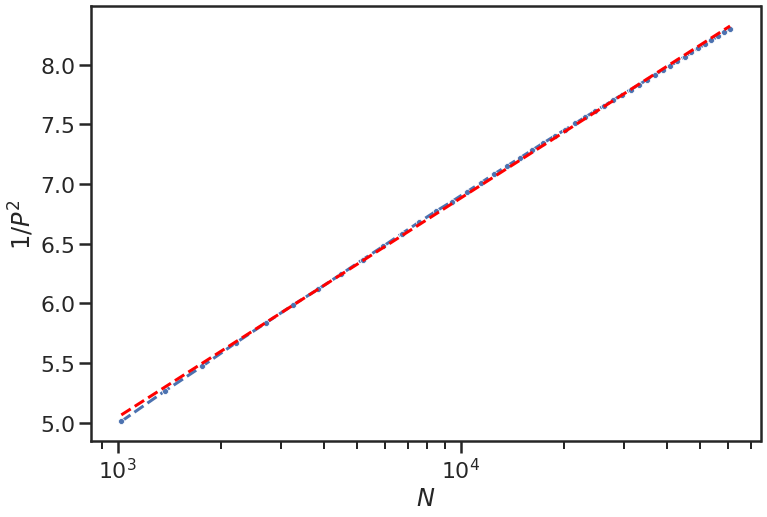

In [9]:
x = np.array(list(data["$N$"]))
y = np.array(list(data["$P$"]))
y = 1/y**2
z, text = lin_fit(np.log(x),y)

plt.figure(figsize=(12,8))
sns.lineplot(x=x,y=y,marker='.', linestyle='--')
sns.lineplot(x=x,y=z, linestyle='--', color="red")
plt.annotate(text, xy=(50, 4),color="red")
plt.xlabel("$N$")
plt.ylabel("$1/P^2$")
plt.xscale("log")